Data inserted successfully!


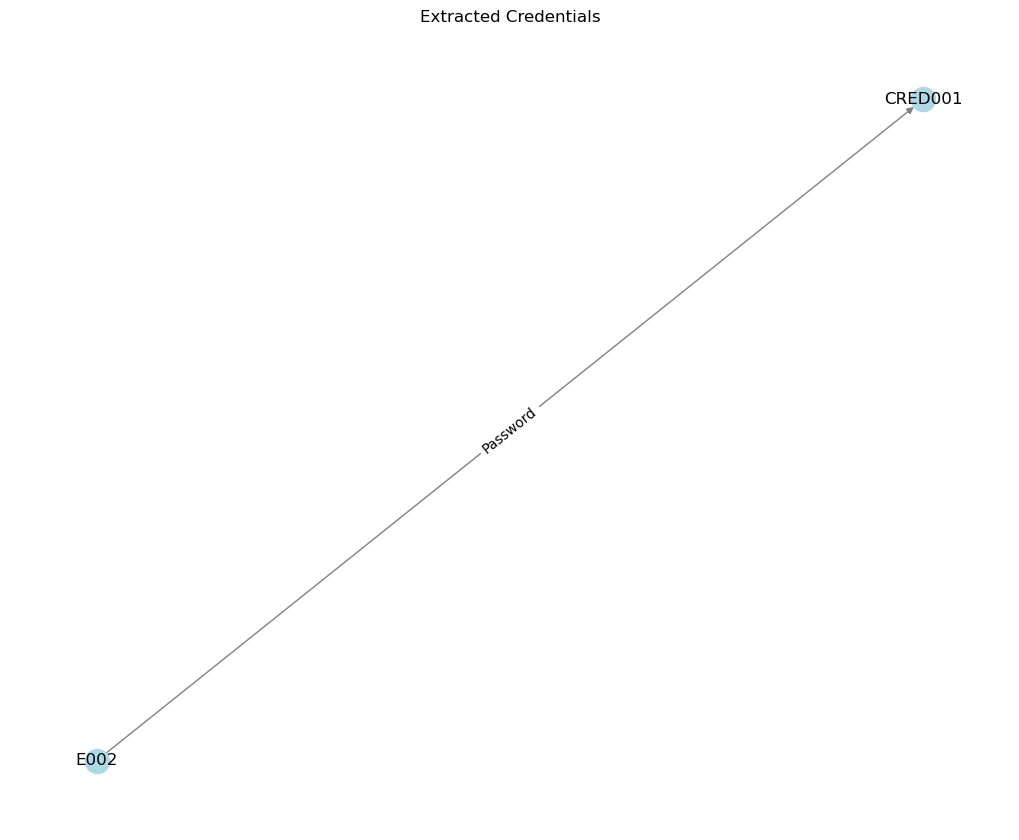

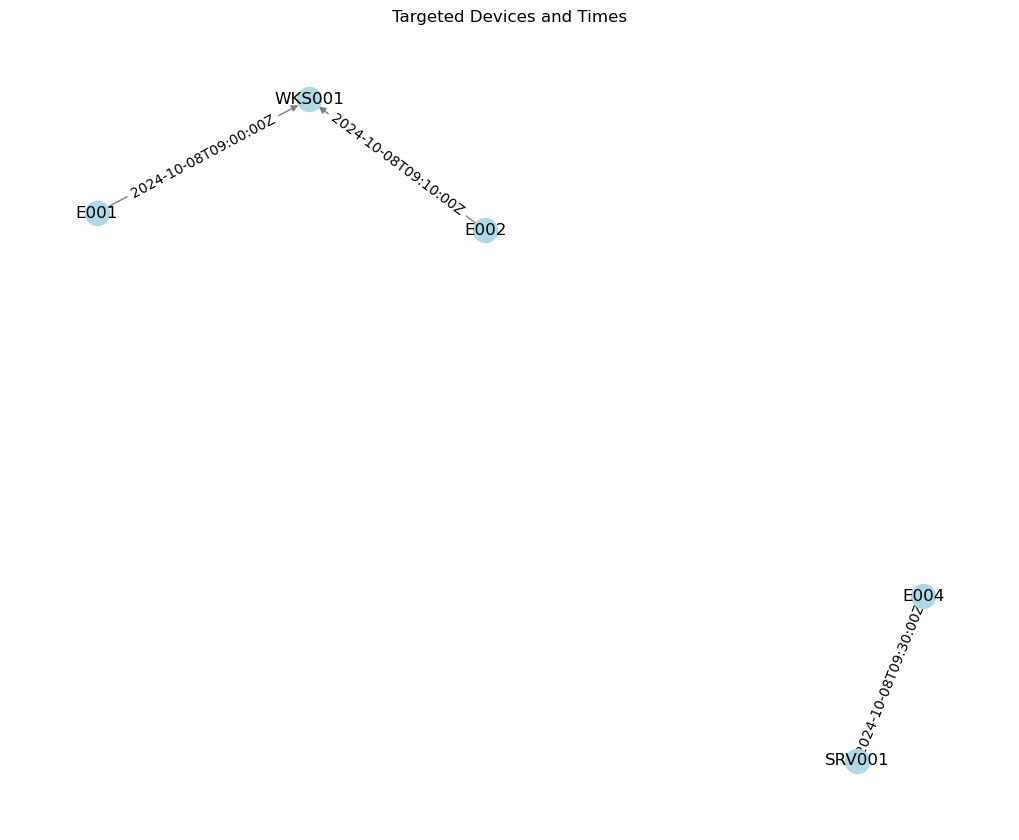

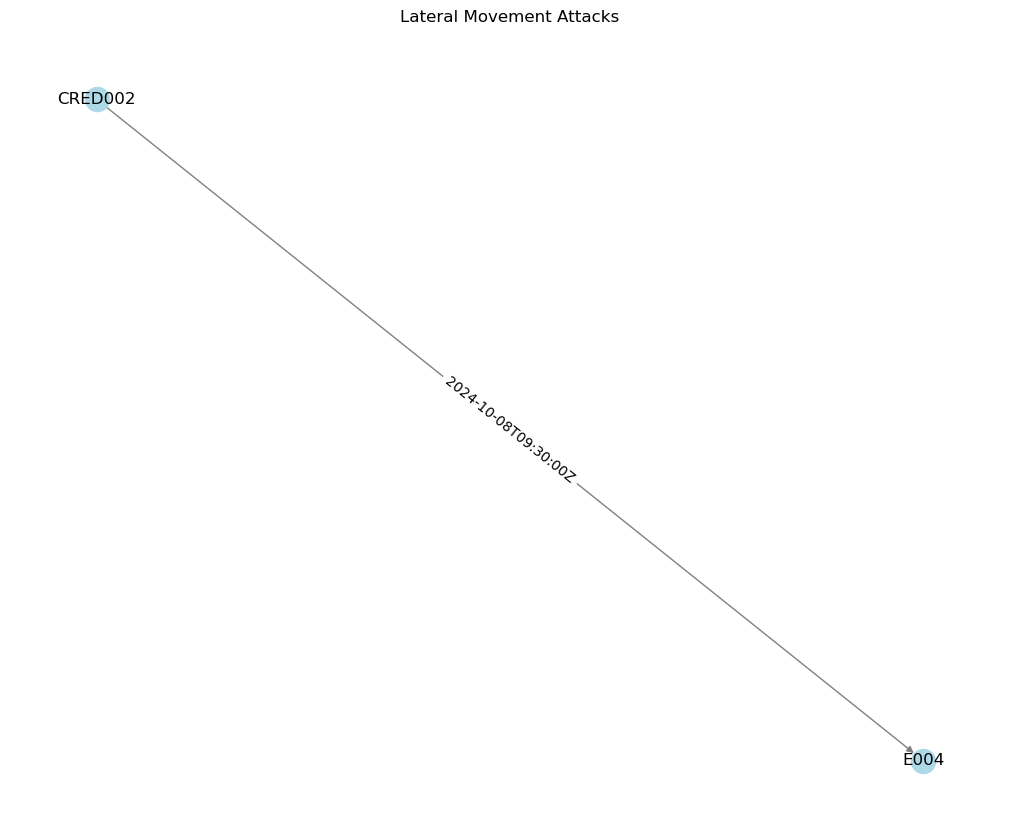

In [ ]:
from py2neo import Graph
import matplotlib.pyplot as plt
import networkx as nx

# 連接 Neo4j 資料庫
graph = Graph("bolt://localhost:7687", auth=("neo4j", "apple0980043"))

# 插入數據
def insert_data():
    # 清除現有數據
    graph.run("MATCH (n) DETACH DELETE n")
    
    # 插入節點數據
    graph.run("CREATE (:IP {ip_address: '192.168.0.101'})")
    graph.run("CREATE (:IP {ip_address: '192.168.0.102'})")
    graph.run("CREATE (:User {user_name: 'attacker', privilege: 'user'})")
    graph.run("CREATE (:User {user_name: 'admin1', privilege: 'admin'})")
    graph.run("CREATE (:User {user_name: 'victim_user', privilege: 'user'})")
    graph.run("CREATE (:Device {device_id: 'WKS001', device_type: 'Workstation'})")
    graph.run("CREATE (:Device {device_id: 'SRV001', device_type: 'Server'})")
    graph.run("CREATE (:AttackEvent {event_id: 'E001', event_type: 'Initial Access', timestamp: '2024-10-08T09:00:00Z'})")
    graph.run("CREATE (:AttackEvent {event_id: 'E002', event_type: 'Credential Dumping', timestamp: '2024-10-08T09:10:00Z'})")
    graph.run("CREATE (:AttackEvent {event_id: 'E003', event_type: 'Privilege Escalation', timestamp: '2024-10-08T09:20:00Z'})")
    graph.run("CREATE (:AttackEvent {event_id: 'E004', event_type: 'Lateral Movement', timestamp: '2024-10-08T09:30:00Z'})")
    graph.run("CREATE (:Credential {credential_id: 'CRED001', credential_type: 'Password'})")
    graph.run("CREATE (:Credential {credential_id: 'CRED002', credential_type: 'Kerberos Ticket'})")
    
    # 插入關係數據
    graph.run("""
        MATCH (ip1:IP {ip_address: '192.168.0.101'}), (event1:AttackEvent {event_id: 'E001'}), (user1:User {user_name: 'attacker'})
        CREATE (ip1)-[:ORIGINATED_FROM]->(event1)
        CREATE (user1)-[:ORIGINATED_FROM]->(event1)
    """)
    graph.run("""
        MATCH (event1:AttackEvent {event_id: 'E001'}), (device1:Device {device_id: 'WKS001'}), (user2:User {user_name: 'victim_user'})
        CREATE (event1)-[:TARGETED]->(device1)
        CREATE (event1)-[:TARGETED]->(user2)
    """)
    graph.run("""
        MATCH (event2:AttackEvent {event_id: 'E002'}), (device1:Device {device_id: 'WKS001'}), (cred1:Credential {credential_id: 'CRED001'})
        CREATE (event2)-[:TARGETED]->(device1)
        CREATE (event2)-[:ACQUIRED]->(cred1)
    """)
    graph.run("""
        MATCH (event3:AttackEvent {event_id: 'E003'}), (cred1:Credential {credential_id: 'CRED001'}), (user3:User {user_name: 'admin1'})
        CREATE (cred1)-[:USED_FOR]->(event3)
        CREATE (event3)-[:TARGETED]->(user3)
    """)
    graph.run("""
        MATCH (event4:AttackEvent {event_id: 'E004'}), (device2:Device {device_id: 'SRV001'}), (cred2:Credential {credential_id: 'CRED002'}), (ip2:IP {ip_address: '192.168.0.102'})
        CREATE (event4)-[:TARGETED]->(device2)
        CREATE (cred2)-[:USED_FOR]->(event4)
        CREATE (ip2)-[:ORIGINATED_FROM]->(event4)
    """)
    print("Data inserted successfully!")

# 查詢與視覺化
def query_and_visualize():
    queries = {
        "Extracted Credentials": """
            MATCH (event:AttackEvent {event_type: 'Credential Dumping'})-[:ACQUIRED]->(cred:Credential)
            RETURN event.event_id, cred.credential_id, cred.credential_type;
        """,
        "Targeted Devices and Times": """
            MATCH (event:AttackEvent)-[:TARGETED]->(device:Device)
            RETURN device.device_id, event.event_id, event.timestamp;
        """,
        "Lateral Movement Attacks": """
            MATCH (cred:Credential)-[:USED_FOR]->(event:AttackEvent {event_type: 'Lateral Movement'})
            RETURN cred.credential_id, event.event_id, event.timestamp;
        """,
    }

    for query_name, query in queries.items():
        result = graph.run(query).data()
        
        # 視覺化
        G = nx.DiGraph()
        for record in result:
            if query_name == "Extracted Credentials":
                G.add_edge(record["event.event_id"], record["cred.credential_id"], label=record["cred.credential_type"])
            elif query_name == "Targeted Devices and Times":
                G.add_edge(record["event.event_id"], record["device.device_id"], label=record["event.timestamp"])
            elif query_name == "Lateral Movement Attacks":
                G.add_edge(record["cred.credential_id"], record["event.event_id"], label=record["event.timestamp"])

        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
        edge_labels = nx.get_edge_attributes(G, "label")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title(query_name)
        plt.show()

# 執行插入與查詢
insert_data()
query_and_visualize()
